# LSAP Data Inspection & Retrieval
---
This notebook contains code for retrieving the polybanking dataset used in our NLP project. 


## Install Libraries & Set Seed

In [1]:
import random, torch
import numpy as np
import pandas as pd

def set_seed( seed ):
    random.seed( seed )
    np.random.seed( seed )
    torch.manual_seed( seed )
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all( seed )

#Set seed for consistency
set_seed(42)

#Set to True to combine all data or False for "train.csv", "val.csv", "test.csv"
SPLIT = False

#Set train, val, and test split sizes
TRAIN_SPLIT = 0.6
VAL_SPLIT   = 0.2
TEST_SPLIT  = 0.2

## Preprocess pre-training dataset

Our pre-training dataset is a combination of the [Banking77 Dataset](https://huggingface.co/datasets/PolyAI/banking77) and [WikiHow Intents Dataset](https://github.com/zharry29/wikihow-intent) with a few tweaks. Below, we load them both in, preprocess them, and get them ready for training our model.

---

### Load PolyBanking Dataset

In [2]:
#Load PolyBanking Dataset from HuggingFace
from datasets import load_dataset, Dataset, concatenate_datasets, ClassLabel
banking_dataset = load_dataset( "PolyAI/banking77", cache_dir="D:\digit\Documents\Development\HuggingFace\Datasets\PolyAIBanking")

#Return Dataframe to perform operations on
banking_dataset.set_format( type="pandas" )
banking_dataset

Found cached dataset banking77 (D:/digit/Documents/Development/HuggingFace/Datasets/PolyAIBanking/PolyAI___banking77/default/1.1.0/aec0289529599d4572d76ab00c8944cb84f88410ad0c9e7da26189d31f62a55b)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

### Preprocessing PolyBanking Dataset
We want to ensure the labels are properly formatted.

In [3]:
#Concatenate train/test into one dataframe
banking_dict = concatenate_datasets( [banking_dataset["train"], banking_dataset["test"]] )

#Extract data from dictionary
banking_df = banking_dict.data.to_pandas()

#Add Label Names for each label
def add_labelname( row ):
  return banking_dataset["train"].features["label"].int2str( row )

def correct_label( row ):
  return " ".join( [word.capitalize() for word in row.split("_")] ) + "."

#Add label name associated with each label
banking_df["label_name"] = banking_df["label"].apply( add_labelname )
banking_df["label_name"] = banking_df["label_name"].apply( correct_label )

In [4]:
banking_df.sample( frac = 1 ).head( 10 )

,text,label,label_name
353,Please explain the exchange rates.,32,Exchange Rate.
10210,I got some cash of an ATM earlier but this sho...,46,Pending Cash Withdrawal.
5361,I just replaced my phone but how do I use my c...,42,Lost Or Stolen Phone.
7051,I wasn't able to do a transfer to an account,7,Beneficiary Not Allowed.
3617,I don't recognize a charge on my statement.,16,Card Payment Not Recognised.
10577,How do I check my security settings to allow c...,23,Contactless Not Working.
6087,What is the average pending time for a transac...,48,Pending Transfer.
2267,is there a limit for top up?,60,Top Up Limits.
7712,Why do we need to verify a top-up card?,71,Verify Top Up.
5576,"I have been doing some online shopping, but wh...",27,Declined Transfer.


### Inspection

Below, we inspect our dataset to look for imbalances in labels, and to see if we need to sample our data differently.

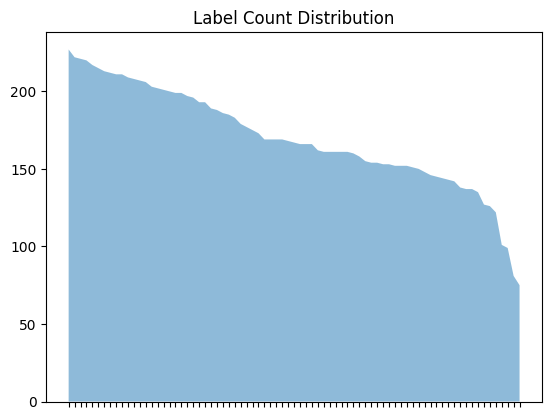

In [5]:
import matplotlib.pyplot as plt

# Get frequency of each label
label_counts = banking_df["label_name"].value_counts()

# Sort the label counts in descending order
sorted_counts = label_counts.sort_values( ascending = False )

# Create a sorted list of labels and their corresponding counts
labels = sorted_counts.index.tolist()
counts = sorted_counts.tolist()

# Create an area graph
plt.stackplot(labels, counts, alpha=0.5)
plt.gca().set_xticklabels([])
plt.title("Label Count Distribution")

plt.show()

### Save Training, Testing, and Validation Data

In [6]:
#Split data into train, validation and test sets
shuffled_df = banking_df.sample( frac = 1, random_state=42 )

#Split data into train, validation and test sets
n = len( shuffled_df )
train_size = int( TRAIN_SPLIT * n )
val_size   = int( VAL_SPLIT   * n ) + train_size
train, validate, test = np.split( shuffled_df, [ train_size, val_size ])

# If combine, then combine train, val and test into one dataframe
if not SPLIT:
    banking_df.to_csv( "data.csv" )
else:
    #Save data to csv files
    train.to_csv( "train.csv" ); validate.to_csv( "val.csv" ); test.to_csv( "test.csv" )